# Novas rodadas (Sprint 4)

Ao final da Sprint 3, tínhamos três modelos de sucesso: um para Rat%, um para Rch% e um para Shr% totais. Oriundos de métodos de LightGBM, esses modelos alcançaram mais de 90% em R² e erros baixíssimos, configurando-se mais que aceitáveis pelas metas determinadas anteriormente. 

No entanto, ainda precisávamos gerar modelos para Fid%, que não chegara a mais de 11% de R² na última Sprint, assim como ampliar os outros tipos de audiência para suas segmentações por demográfico, como idade, gênero e classe socioeconômica.



In [ ]:
# Importando as bibliotecas necessárias para todo o notebook
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Rodada 6: sem BBB

Na rodada 3, adicionamos novas features aos modelos testados: dia do mês, hora, minuto, feriado e BBB. Esta última, em particular, associava um valor binário positivo às entradas cuja programação era BBB. Porém, ao analisar essa abordagem com mais atenção, percebemos que estávamos considerando essa característica de modo duplicado, pois o one-hot encoding das categorias já apresentava uma coluna binária para a programação de BBB. Assim, entendemos que essa feature poderia enviesar os dados e, portanto, testamos os modelos da Rodada 3 sem ela.

Começamos, como sempre, preparando os dados. Nesse sentido, seguimos as mesmas etapas da Rodada 3 com exceção da adição da coluna de BBB.

In [ ]:
# Abre planilha original
df = pd.read_csv('/content/drive/MyDrive/Sprint 4/arquivos_fonte/emissora.csv')

In [ ]:
# Define função para separar o dia
def segregate_day(df):
  # Guarda datas da coluna 'Data' como objetos na variável 'dates'
  dates = pd.to_datetime(df['Data'])
  days = []
  # Este loop adiciona o dia de cada data em um array 'days'
  for date in dates:
    days.append(date.day)
  # Cria coluna 'Dia' com array 'days'
  df['Dia'] = days
  # Retorna df modificada
  return df

In [ ]:
# Executa segregação de dias
df = segregate_day(df)

In [ ]:
from datetime import date # Importa objeto de datas
import holidays # Importa biblioteca de feriados

holidays = holidays.Brazil() # Cria objeto de feriados brasileiros

# Esta função checa o valor de 'Data' de certa linha e, se ele estiver associado
# a um feriado do objeto 'holidays', retorna 1. Caso contrário, retorna 0.
def feriado(row): 
  if pd.to_datetime(row['Data']) in holidays:
    return 1
  return 0

# A função apply aplica a função "feriado" a todas as linhas da dataframe.
# O valor retornado é adicionado a uma nova coluna chamada "Feriado".
# Desse modo, datas de feriado ficam com 1 nessa coluna, enquanto as outras ficam
# com 0
df['Feriado'] = df.apply(lambda row: feriado(row), axis=1)

In [ ]:
# Este método transforma os valores únicos de uma coluna em colunas individuais auxiliares,
# seguindo o modelo de one-hot encoding. O parâmetro "prefix" determina o prefixo de cada coluna.
dummies = pd.get_dummies(df['Categoria'], prefix='Categoria')

# Concatena colunas auxiliares com planilha existente
df = pd.concat([df, dummies], axis=1)

# Deleta coluna de categorias original
df.pop('Categoria')

0         JORNALISMO
1         JORNALISMO
2         JORNALISMO
3         JORNALISMO
4         JORNALISMO
             ...    
218846    JORNALISMO
218847    JORNALISMO
218848    JORNALISMO
218849    JORNALISMO
218850    JORNALISMO
Name: Categoria, Length: 218851, dtype: object

In [ ]:
series = df['Hora Início'] # Isola coluna de horários
hours = [] # Inicia array para guardar unidades de hora
minutes = [] # Inicia array para guardar unidades de minuto

# Este loop passa por cada item da coluna de horário, acessa as unidades através
# dos indexes do valor em string, transforma em inteiro e salva no array
for time in series:
  hours.append(int(time[:2])) # A hora corresponde aos caracteres 0 e 1
  # O caractere 2 é ":" no formato "xx:xx:xx"
  minutes.append(int(time[3:5])) # O minuto corresponde aos caracteres 3 e 4

# Os arrays são adicionados como colunas na dataframe
df['Hora'] = hours
df['Minuto'] = minutes

In [ ]:
# Salva planilha resultante para uso futuro
df.to_csv('/content/drive/MyDrive/Sprint 4/arquivos_fonte/sem_bbb.csv', index=False)

Então, dividimos os dados em conjunto de treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split

model = df.copy() # Copia dataframe

# Dividindo x e y
y = model['Total Domicílios | Rat%'].values # Score de audiência
x = model[['Dia da Semana',
       'Mês', 'Dia', 'Hora', 'Minuto', 'Feriado',  'Categoria_AUDITORIO', 'Categoria_CARROS E MOTORES',
       'Categoria_CULINARIO', 'Categoria_DEBATE', 'Categoria_DOCUMENTARIO',
       'Categoria_EDUCATIVO', 'Categoria_ENTREVISTA', 'Categoria_ESPORTE',
       'Categoria_FEMININO', 'Categoria_FILME', 'Categoria_FUTEBOL',
       'Categoria_GAME SHOW', 'Categoria_HUMORISTICO', 'Categoria_JORNALISMO',
       'Categoria_MINISSERIE', 'Categoria_MUSICAL', 'Categoria_NOVELA',
       'Categoria_POLITICO', 'Categoria_PREMIACAO', 'Categoria_REALITY SHOW',
       'Categoria_RELIGIOSO', 'Categoria_REPORTAGEM', 'Categoria_RURAL',
       'Categoria_SERIES', 'Categoria_SHOW']].values # Features de data, hora e categoria

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [ ]:
# Cria dicionário para guardar resultados de R² de todos os modelos para facilitar a geração de gráficos
results = {}

### Regressão linear

Com isso, começamos a gerar os modelos, iniciando pelo de regressão linear.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# Treinando o modelo
linear_regression = LinearRegression().fit(x_train, y_train)

# Testando o modelo
y_pred = linear_regression.predict(x_test)

# Avaliando testes
# Erro médio absoluto
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))

# Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
# decimais para facilitar a visualização
percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
print("Erro médio percentual: " + percentual_error + "%")

# R²
r2 = r2_score(y_test, y_pred)
print("R²: " + str(r2))

# R² ajustado
r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print("R² ajustado: " + str(r2))

results['Regressão Linear'] = r2

Erro médio: 3.830982933226498
Erro médio percentual: 38.65%
R²: 0.4158912371517206
R² ajustado: 0.4158912371517206


O resultado é tão baixo quanto os anteriores, mostrando que não vale a pena testar regressão linear com nossos dados, pois os resultados sempre ficam muito abaixo das médias esperadas.

### KNN

Rodamos o algoritmo de KNN para os melhores valores de k nas rodadas anteriores e geramos um gráfico de comparação.

In [ ]:
knns = {} # Dicionário para guardar resultados de KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Esta função aplica o algoritmo de KNN para k vizinhos e mostra as métricas associadas.
# Criamos esta função para não ficar repetindo esse trecho de código nesta subseção do Colab.
def evaluate_knn(k):
  knn = KNeighborsRegressor(n_neighbors=k) # Cria objeto de KNN com k (argumento) vizinhos
  knn.fit( x_train, y_train.squeeze()) # Treina modelo
  y_pred = knn.predict(x_test) # Testa modelo

  # Erro médio absoluto
  mean_absolute = mean_absolute_error(y_test, y_pred)
  print("Erro médio: " + str(mean_absolute))

  # Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
  # decimais para facilitar a visualização
  percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
  print("Erro médio percentual: " + percentual_error + "%")

  # R²
  r2 = r2_score(y_test, y_pred)
  print("R²: " + str(r2))

  # R² ajustado
  r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
  print("R² ajustado: " + str(r2))

  knns[k] = r2 # Salva o r2 atual no dicionário, associado ao k utilizado

In [ ]:
evaluate_knn(2)

Erro médio: 2.282835917509443
Erro médio percentual: 23.03%
R²: 0.7578041754870333
R² ajustado: 0.7578041754870333


In [ ]:
evaluate_knn(3)

Erro médio: 2.16070224605012
Erro médio percentual: 21.8%
R²: 0.7853421246122811
R² ajustado: 0.7853421246122811


In [ ]:
evaluate_knn(7)

Erro médio: 2.0870419197897263
Erro médio percentual: 21.06%
R²: 0.80326066204431
R² ajustado: 0.80326066204431


In [ ]:
evaluate_knn(9)

Erro médio: 2.1013881781135346
Erro médio percentual: 21.2%
R²: 0.8006048777200868
R² ajustado: 0.8006048777200868


In [ ]:
results['KNN'] = knns # Salva o dicionário de KNN no dicionário geral de resultados

Para gerar o gráfico, utilizamos a biblioteca Seaborn, que oferece designs mais esteticamente agradáveis e um código mais enxuto.

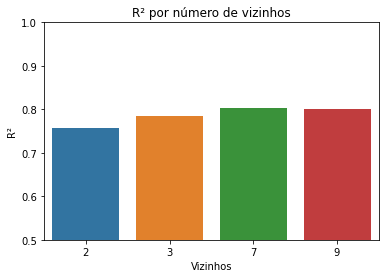

In [ ]:
# Importa bibliotecas necessárias
import seaborn as sns
import matplotlib.pyplot as plt

# Salva chaves do subdicionário de KNN como eixo x
x_axis = [int(i) for i in results['KNN'].keys()]
# Salva valores do subdicionário de KNN como eixo y
y_axis = [i for i in results['KNN'].values()]

# Plota dados
ax = sns.barplot(x=x_axis, y=y_axis)

# Define legendas e título
ax.set(xlabel='Vizinhos', ylabel='R²', title='R² por número de vizinhos')
# Define gradação do eixo y
ax.set(ylim=(0.5, 1))

# Mostra gráfico
plt.show()

### Decision tree

Assim como na rodada 3, para o algoritmo de árvore decisória, nós experimentamos tanto parâmetros (profundidade máxima) automáticos quanto manuais. 

In [ ]:
dts = {} # Dicionário para guardar resultados de decision tree

In [ ]:
# Define função para profundidade customizada

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_dt(depth):
  # Cria objeto de decision tree com profundidade depth (argumento)
  dt = DecisionTreeRegressor(max_depth=depth) 
  dt.fit(x_train, y_train.squeeze()) # Cria decision tree com base em dados de treino
  y_pred = dt.predict(x_test) # Faz predições para dataset de test

  # Erro médio absoluto
  mean_absolute = mean_absolute_error(y_test, y_pred)
  print("Erro médio: " + str(mean_absolute))

  # Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
  # decimais para facilitar a visualização
  percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
  print("Erro médio percentual: " + percentual_error + "%")

  # R²
  r2 = r2_score(y_test, y_pred)
  print("R²: " + str(r2))

  # R² ajustado
  r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
  print("R² ajustado: " + str(r2))

  dts[depth] = r2 # Salva r2 atual no dicionário

Testamos também a regressão automática:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Objeto com argumentos vazios, para indicar profundidade automática
dt = DecisionTreeRegressor()
dt.fit( x_train, y_train.squeeze() ) # Treina modelo
y_pred = dt.predict(x_test) # Testa modelo

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Erro médio absoluto
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))

# Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
# decimais para facilitar a visualização
percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
print("Erro médio percentual: " + percentual_error + "%")

# R²
r2 = r2_score(y_test, y_pred)
print("R²: " + str(r2))

# R² ajustado
r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print("R² ajustado: " + str(r2))

dts['auto'] = r2 # Salva regressão automática como 'auto' no dicionário

Erro médio: 0.8986377482636774
Erro médio percentual: 9.07%
R²: 0.9402936512719349
R² ajustado: 0.9402936512719349


Rodamos a função customizada para vários valores com boa performance na rodada 3.

In [ ]:
evaluate_dt(2)

Erro médio: 3.4516499111460535
Erro médio percentual: 34.82%
R²: 0.47485939087072615
R² ajustado: 0.47485939087072615


In [ ]:
evaluate_dt(3)

Erro médio: 2.8741950000215954
Erro médio percentual: 29.0%
R²: 0.6185183584281579
R² ajustado: 0.6185183584281579


In [ ]:
evaluate_dt(10)

Erro médio: 1.8676829937162056
Erro médio percentual: 18.84%
R²: 0.8408258060614066
R² ajustado: 0.8408258060614066


In [ ]:
evaluate_dt(20)

Erro médio: 1.1180420660648325
Erro médio percentual: 11.28%
R²: 0.9261688248625596
R² ajustado: 0.9261688248625596


In [ ]:
evaluate_dt(25)

Erro médio: 0.934043691557914
Erro médio percentual: 9.42%
R²: 0.9380033525709707
R² ajustado: 0.9380033525709707


In [ ]:
evaluate_dt(30)

Erro médio: 0.8989616222648625
Erro médio percentual: 9.07%
R²: 0.9403533648944566
R² ajustado: 0.9403533648944566


In [ ]:
evaluate_dt(35)

Erro médio: 0.8991576209623607
Erro médio percentual: 9.07%
R²: 0.9398122114591573
R² ajustado: 0.9398122114591573


In [ ]:
evaluate_dt(37)

Erro médio: 0.8967443950286341
Erro médio percentual: 9.05%
R²: 0.9405277725238839
R² ajustado: 0.9405277725238839


In [ ]:
evaluate_dt(40)

Erro médio: 0.8948723650542219
Erro médio percentual: 9.03%
R²: 0.940872888840858
R² ajustado: 0.940872888840858


In [ ]:
results['Decision tree'] = dts # Salva todos os resultados no dicionário geral

Então, geramos mais um gráfico com seaborn:

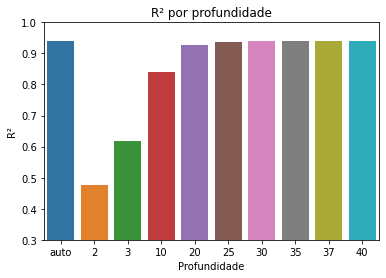

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Salva chaves e valores do dicionário nos eixos
x_axis = [i for i in list(results['Decision tree'].keys())]
y_axis = [i for i in results['Decision tree'].values()]

ax = sns.barplot(x=x_axis, y=y_axis) # Plota

# Define títulos e legendas
ax.set(xlabel='Profundidade', ylabel='R²', title='R² por profundidade')

# Define gradação
ax.set(ylim=(0.30, 1))

plt.show() # Mostra gráfico

### Random forest generator

Assim como na rodada 3, resolvemos testar vários argumentos para estimadores a fim de encontrar um valor ótimo. A suposição era de que esse algoritmo tivesse melhores resultados do que a decision tree, dado que ele tira a média de diversas árvores decisórias. Novamente, redefinimos a função.

In [ ]:
forests = {} # Dicionário para guardar todos os valores

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_forest(estimators):
  # Cria objeto de floresta
  regressor = RandomForestRegressor(n_estimators=estimators, random_state=0)
  # Treina modelo
  regressor.fit(x_train, y_train)
  # Testa modelo
  y_pred = regressor.predict(x_test)

  # Erro médio absoluto
  mean_absolute = mean_absolute_error(y_test, y_pred)
  print("Erro médio: " + str(mean_absolute))

  # Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
  # decimais para facilitar a visualização
  percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
  print("Erro médio percentual: " + percentual_error + "%")

  # R²
  r2 = r2_score(y_test, y_pred)
  print("R²: " + str(r2))

  # R² ajustado
  r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
  print("R² ajustado: " + str(r2))

  forests[estimators] = r2 # Guarda r2 no dicionário

In [ ]:
evaluate_forest(20)

Erro médio: 0.8968438985012793
Erro médio percentual: 9.05%
R²: 0.9569589292511863
R² ajustado: 0.9569589292511863


In [ ]:
evaluate_forest(100)

Erro médio: 0.8746872441208724
Erro médio percentual: 8.82%
R²: 0.9595839195076874
R² ajustado: 0.9595839195076874


In [ ]:
evaluate_forest(200)

Erro médio: 0.8719978745278419
Erro médio percentual: 8.8%
R²: 0.9599161485095925
R² ajustado: 0.9599161485095925


In [ ]:
results['Random forest'] = forests # Guarda resultados no dicionário geral

Gerando o gráfico:

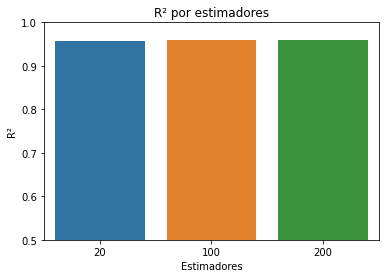

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cria eixos com base nos dicionários
x_axis = [i for i in list(results['Random forest'].keys())]
y_axis = [i for i in results['Random forest'].values()]

ax = sns.barplot(x=x_axis, y=y_axis) # Plota

# Define título e legendas
ax.set(xlabel='Estimadores', ylabel='R²', title='R² por estimadores')

# Define gradação do eixo y
ax.set(ylim=(0.50, 1))

plt.show() # Mostra gráfico

In [ ]:
results_rodada_6 = results.copy()

## Rodada 7: Sem BBB (random search)

Na Sprint 4, descobrimos ser possível otimizar parâmetros através de Grid e Random Search. Essas ferramentas testam diferentes combinações de modo exaustivo ou aleatório, respectivamente, dentro de intervalos passados para cada hiperparâmetro do algoritmo de indução. Inicialmente, essa abordagem pareceu redundante, pois já havíamos feito esse processo de forma manual nas sprints passadas, testando diferentes permutações de hiperparâmetros em busca do melhor custo-benefício de tempo e R². Ainda assim, observando melhor, percebemos que essas técnicas poderiam ser muito úteis em validar nosso raciocínio.

Desse modo, decidimos executar o Random Search para nossa melhor rodada até então (rodada 6). Escolhemos apenas o Random para economizar tempo, dado que já tínhamos boas hipóteses sobre quais seriam os melhores intervalos e queríamos apenas confirmar nossas ideias em vez de selecionar hiperparâmetros do zero.


In [ ]:
# Separa conjuntos de teste e treino

from sklearn.model_selection import train_test_split

random_model = df.copy() # Copia dataframe

# Dividindo x e y
y = random_model['Total Domicílios | Rat%'].values # Score de audiência
x = random_model[['Dia da Semana',
       'Mês', 'Dia', 'Hora', 'Minuto', 'Feriado',  'Categoria_AUDITORIO', 'Categoria_CARROS E MOTORES',
       'Categoria_CULINARIO', 'Categoria_DEBATE', 'Categoria_DOCUMENTARIO',
       'Categoria_EDUCATIVO', 'Categoria_ENTREVISTA', 'Categoria_ESPORTE',
       'Categoria_FEMININO', 'Categoria_FILME', 'Categoria_FUTEBOL',
       'Categoria_GAME SHOW', 'Categoria_HUMORISTICO', 'Categoria_JORNALISMO',
       'Categoria_MINISSERIE', 'Categoria_MUSICAL', 'Categoria_NOVELA',
       'Categoria_POLITICO', 'Categoria_PREMIACAO', 'Categoria_REALITY SHOW',
       'Categoria_RELIGIOSO', 'Categoria_REPORTAGEM', 'Categoria_RURAL',
       'Categoria_SERIES', 'Categoria_SHOW']].values # Features de data, hora e categoria

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

### KNN

Para KNN, escolhemos o intervalo de 5 a 30. Até então, nosso melhor modelo havíamos testado k de 1 a 9, tendo como ápice k = 7. Queríamos, portanto, garantir que não existiam picos ainda melhores com valores maiores; ainda assim, devido a limites computacionais e de tempo, limitamos o máximo a 30.

In [ ]:
# Importa biblioteca de KNN e random search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor() # Cria objeto KNN

# Cria argumentos para o algoritmo com base no intervalo desejado
k_range = list(range(5, 30)) # Criar range desejado
param_grid = dict(n_neighbors=k_range) # Transforma range em dicionário de parâmetros

# Cria objeto de random search para modelo knn, com parâmetros do grid criado, 
# 3 rodadas de cross-validation e 10 iterações. O verbose=2 solicita que sejam printadas
# as etapas conforme elas acontecem para que se saiba o que está acontecendo durante a 
# execução do programa.
randomized_search = RandomizedSearchCV(knn, param_grid, cv=3, n_iter=10, verbose=2)

In [ ]:
randomized_search.fit(x_train, y_train) # Treina

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................................n_neighbors=22; total time= 1.9min
[CV] END .....................................n_neighbors=22; total time= 1.8min
[CV] END .....................................n_neighbors=22; total time= 1.8min
[CV] END .....................................n_neighbors=13; total time= 1.7min
[CV] END .....................................n_neighbors=13; total time= 1.8min
[CV] END .....................................n_neighbors=13; total time= 1.8min
[CV] END .....................................n_neighbors=24; total time= 1.8min
[CV] END .....................................n_neighbors=24; total time= 1.7min
[CV] END .....................................n_neighbors=24; total time= 1.7min
[CV] END ......................................n_neighbors=7; total time= 1.7min
[CV] END ......................................n_neighbors=7; total time= 1.7min
[CV] END ......................................n

RandomizedSearchCV(cv=3, estimator=KNeighborsRegressor(),
                   param_distributions={'n_neighbors': [5, 6, 7, 8, 9, 10, 11,
                                                        12, 13, 14, 15, 16, 17,
                                                        18, 19, 20, 21, 22, 23,
                                                        24, 25, 26, 27, 28,
                                                        29]},
                   verbose=2)

In [ ]:
print(randomized_search.best_params_) # Printa melhores parâmetros

{'n_neighbors': 7}


Testamos o hiperparâmetro otimizado para checar suas métricas:


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cria objeto de knn
knn = KNeighborsRegressor(n_neighbors=7) 
knn.fit(x_train, y_train.squeeze()) # Cria knn com base em dados de treino
y_pred = knn.predict(x_test) # Faz predições para dataset de teste

# Erro médio absoluto
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))

# Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
# decimais para facilitar a visualização
percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
print("Erro médio percentual: " + percentual_error + "%")

# R²
r2 = r2_score(y_test, y_pred)
print("R²: " + str(r2))

# R² ajustado
r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print("R² ajustado: " + str(r2))

Erro médio: 2.0870419197897263
Erro médio percentual: 21.06%
R²: 0.80326066204431
R² ajustado: 0.80326066204431


### Decision Tree

Na rodada 6, nosso melhor modelo de decision tree havia sido o de 40 níveis de profundidade. Portanto, determinamos o intervalo de 25 a 50 para o random search da rodada 7, para contemplar os valores próximos ao ápice e averiguar se era possível conseguir resultados semelhantes com um menor número de níveis. 


In [ ]:
# Importa biblioteca de KNN e random search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

dt = DecisionTreeRegressor() # Cria objeto de decision tree

# Cria argumentos para o algoritmo com base no intervalo desejado
depth_range = list(range(25, 50)) # Criar range desejado
param_grid = dict(max_depth=depth_range) # Transforma range em dicionário de parâmetros

# Cria objeto de random search para modelo dt, com parâmetros do grid criado, 
# 3 rodadas de cross-validation e 10 iterações.
randomized_search = RandomizedSearchCV(dt, param_grid, cv=3, n_iter=10, verbose=2)

In [ ]:
randomized_search.fit(x_train, y_train) # Treina

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .......................................max_depth=41; total time=   0.8s
[CV] END .......................................max_depth=41; total time=   0.7s
[CV] END .......................................max_depth=41; total time=   0.7s
[CV] END .......................................max_depth=46; total time=   0.7s
[CV] END .......................................max_depth=46; total time=   0.7s
[CV] END .......................................max_depth=46; total time=   0.7s
[CV] END .......................................max_depth=40; total time=   0.7s
[CV] END .......................................max_depth=40; total time=   0.7s
[CV] END .......................................max_depth=40; total time=   0.7s
[CV] END .......................................max_depth=44; total time=   0.7s
[CV] END .......................................max_depth=44; total time=   0.7s
[CV] END .......................................

RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [25, 26, 27, 28, 29, 30,
                                                      31, 32, 33, 34, 35, 36,
                                                      37, 38, 39, 40, 41, 42,
                                                      43, 44, 45, 46, 47, 48,
                                                      49]},
                   verbose=2)

In [ ]:
print(randomized_search.best_params_) # Printa melhores parâmetros

{'max_depth': 28}


Então, testamos 28 de profundidade em um modelo à parte, para checar todas as métricas:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

dt = DecisionTreeRegressor(max_depth=28) 
dt.fit(x_train, y_train.squeeze()) # Cria decision tree com base em dados de treino
y_pred = dt.predict(x_test) # Faz predições para dataset de test

# Erro médio absoluto
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))

# Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
# decimais para facilitar a visualização
percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
print("Erro médio percentual: " + percentual_error + "%")

# R²
r2 = r2_score(y_test, y_pred)
print("R²: " + str(r2))

# R² ajustado
r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print("R² ajustado: " + str(r2))

Erro médio: 0.9053855191545851
Erro médio percentual: 9.13%
R²: 0.9399598874368328
R² ajustado: 0.9399598874368328


Como esse foi nosso melhor modelo, segundo as conclusões da comparação de modelos, tentamos gerar o gráfico da árvore na célula abaixo. Entretanto, essa função foi muito pesada para o Colab e não pôde ser rodada até o final.

In [127]:
from sklearn import tree # Importa biblioteca de gráfico de árvore

tree.plot_tree(dt) # Plota

[Text(0.7340467868665358, 0.9827586206896551, 'X[22] <= 0.5\nsquared_error = 42.388\nsamples = 153195\nvalue = 9.93'),
 Text(0.5373501086249097, 0.9482758620689655, 'X[3] <= 24.5\nsquared_error = 30.341\nsamples = 131696\nvalue = 8.535'),
 Text(0.3273086188898601, 0.9137931034482759, 'X[3] <= 11.5\nsquared_error = 27.845\nsamples = 100006\nvalue = 10.184'),
 Text(0.15924439472711366, 0.8793103448275862, 'X[19] <= 0.5\nsquared_error = 5.738\nsamples = 38258\nvalue = 6.583'),
 Text(0.08918492285893155, 0.8448275862068966, 'X[13] <= 0.5\nsquared_error = 6.131\nsamples = 20213\nvalue = 5.96'),
 Text(0.05038376014690243, 0.8103448275862069, 'X[3] <= 6.5\nsquared_error = 4.371\nsamples = 17730\nvalue = 5.544'),
 Text(0.005978109109923719, 0.7758620689655172, 'X[4] <= 27.5\nsquared_error = 1.881\nsamples = 1731\nvalue = 3.599'),
 Text(0.0030527104936076102, 0.7413793103448276, 'X[4] <= 17.5\nsquared_error = 1.488\nsamples = 881\nvalue = 3.164'),
 Text(0.0018937968674386657, 0.7068965517241379

Error in callback <function flush_figures at 0x7ff6fcb2b050> (for post_execute):


KeyboardInterrupt: ignored

Ainda assim, conseguimos gerar uma representação textual do modelo:

In [ ]:
from sklearn import tree # Importa biblioteca de gráfico de árvore

text_representation = tree.export_text(dt) # Exporta texto
print(text_representation) # Printa texto

|--- feature_22 <= 0.50
|   |--- feature_3 <= 24.50
|   |   |--- feature_3 <= 11.50
|   |   |   |--- feature_19 <= 0.50
|   |   |   |   |--- feature_13 <= 0.50
|   |   |   |   |   |--- feature_3 <= 6.50
|   |   |   |   |   |   |--- feature_4 <= 27.50
|   |   |   |   |   |   |   |--- feature_4 <= 17.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 3.50
|   |   |   |   |   |   |   |   |   |--- feature_1 <= 10.50
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  1.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |--- feature_1 >  10.50
|   |   |   |   |   |   |   |   |   |   |--- feature_4 <= 2.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [4.07]
|   |   |   |   |   |   |   |   |   |   |--- feature_4 >  2.50
|   |   |   |   |   |   |   |   |   |   |   |--- trun

### Random Forest

Para random forest, consideramos um intervalo de 20 a 200 estimadores, pois nosso melhor resultado, até, então, havia ocorrido com 200, mas demandado tempo demais com treinamento. Queríamos, portanto, alcançar um resultado semelhante com menos árvores. 
Rodamos o random search localmente para otimizar o tempo, pois já estávamos chegando a duas horas de execução no Colab. O código utilizado está disponível nas células abaixo, mas as imagens provêm do output local no VS Code.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor() # Cria objeto de random forest

# Cria argumentos no formato correto, no intervalo de 20 a 200
estimators = list(range(20, 200))
param_grid = dict(n_estimators=estimators)

# Cria objeto de random search
randomized_search = RandomizedSearchCV(rf, param_grid, cv=3, n_iter=10, verbose=1)

In [ ]:
randomized_search.fit(x_train, y_train) # Treina

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: ignored

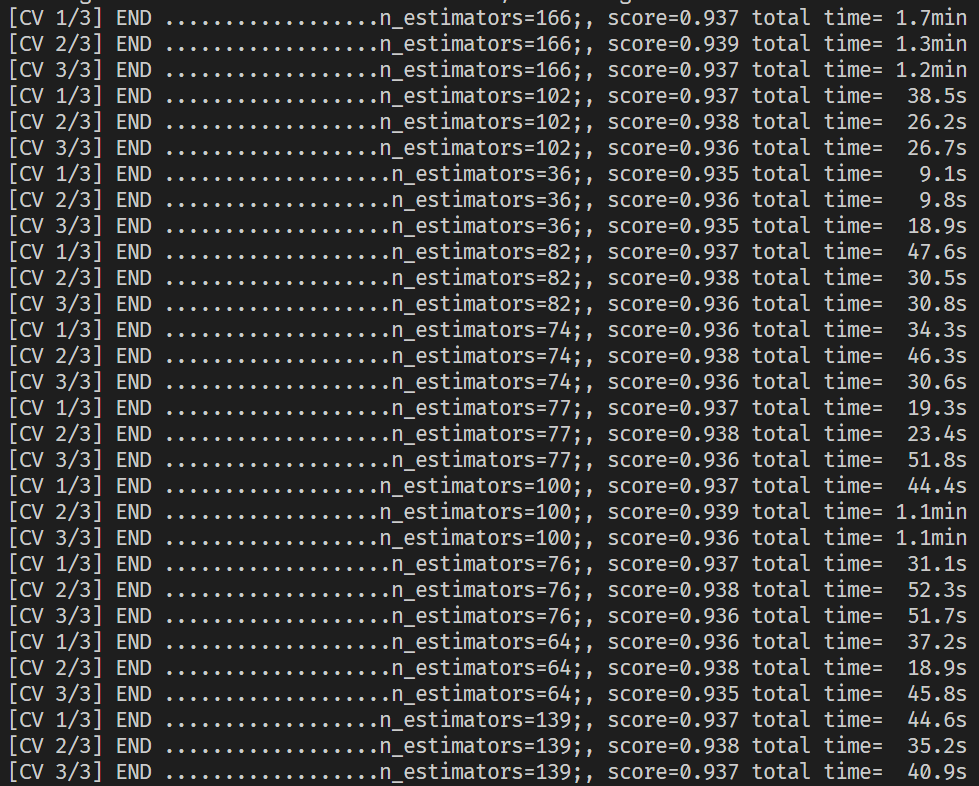

In [ ]:
print(randomized_search.best_params_) # Printa resultados

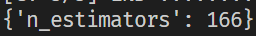

Novamente, testamos a sugestão de hiperparâmetro e checamos as métricas resultantes:

In [ ]:
regressor = RandomForestRegressor(n_estimators=166, random_state=0)
# Treina modelo
regressor.fit(x_train, y_train)
# Testa modelo
y_pred = regressor.predict(x_test)

# Erro médio absoluto
mean_absolute = mean_absolute_error(y_test, y_pred)
print("Erro médio: " + str(mean_absolute))

# Erro médio absoluto em porcentagem (erro / média), arredondado para duas casas
# decimais para facilitar a visualização
percentual_error = str(round((mean_absolute/y_test.mean() * 100), 2))
print("Erro médio percentual: " + percentual_error + "%")

# R²
r2 = r2_score(y_test, y_pred)
print("R²: " + str(r2))

# R² ajustado
r2_adjusted = 1 - (1 - r2) * (len(y) - 1) / (len(y) - x.shape[1] - 1)
print("R² ajustado: " + str(r2))

Erro médio: 0.8722437501926801
Erro médio percentual: 8.8%
R²: 0.9598184105363474
R² ajustado: 0.9598184105363474


Esse resultado não é muito diferente do atingido com 200 estimadores, porém rodou em bem menos tempo. Em suma, conseguimos parâmetros otimizados para todos os nossos modelos, fazendo desta rodada um sucesso. 